In [1]:
import pandas as pd

# Read the datasets
daily_returns = pd.read_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Codigos\Crypto_daily_data.xlsx")
weekly_returns = pd.read_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Codigos\Crypto_weekly_data.xlsx")
df_market_cap = pd.read_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Codigos\Market_cap_data.xlsx")
# Initialize an empty dictionary to store the results
crypto_missing_returns = {}

# Iterate through each unique cryptocurrency in the dataset
for crypto in daily_returns['Symbol'].unique():
    # Filter the returns for the current cryptocurrency
    crypto_data = daily_returns[daily_returns['Symbol'] == crypto]
    
    # Find the first date with non-null return value
    first_return_date = crypto_data['Date'].loc[crypto_data['Daily Returns'].notna()].min()
    
    # Find the last date with non-null return value
    last_return_date = crypto_data['Date'].loc[crypto_data['Daily Returns'].notna()].max()
    
    # Create a list of dates where returns are missing after the first return
    missing_dates = crypto_data['Date'].loc[(crypto_data['Date'] > first_return_date) & (crypto_data['Date'] < last_return_date) & (crypto_data['Daily Returns'].isna())].tolist()
    
    # Add the cryptocurrency and its missing dates to the dictionary
    if missing_dates:
        crypto_missing_returns[crypto] = missing_dates

# Print the cryptocurrencies and their missing dates
for crypto, missing_dates in crypto_missing_returns.items():
    print(f"Cryptocurrency {crypto} has missing returns on the following dates after the initial return:")
    print(missing_dates)
    print()


# Convert the 'Date' column in daily_returns to Timestamp
daily_returns['Date'] = pd.to_datetime(daily_returns['Date'])


In [2]:
""" import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = "^CMC200"

# Define the date range
start_date = daily_returns["Date"].min()
end_date = daily_returns["Date"].max()

# Get data for the specified ticker within the date range
index_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1wk')

# Calculate weekly returns
index_data['Weekly_Return'] = index_data['Adj Close'].pct_change()

# Print the first few rows of the data
display(index_data) """


' import yfinance as yf\nimport pandas as pd\n\n# Define the ticker symbol\nticker_symbol = "^CMC200"\n\n# Define the date range\nstart_date = daily_returns["Date"].min()\nend_date = daily_returns["Date"].max()\n\n# Get data for the specified ticker within the date range\nindex_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval=\'1wk\')\n\n# Calculate weekly returns\nindex_data[\'Weekly_Return\'] = index_data[\'Adj Close\'].pct_change()\n\n# Print the first few rows of the data\ndisplay(index_data) '

In [3]:
index_data = pd.read_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Data\Reg_factors - copia NO EDITAR.xlsx", usecols=[0,2])

index_data = index_data.rename(columns={index_data.columns[1]: 'Weekly_Return'})
index_data = index_data.set_index('Date')


In [4]:
# Get unique dates from index_data
unique_dates = index_data.index.unique()

# Initialize an empty DataFrame to store filtered returns
filtered_returns = pd.DataFrame()

# Loop through each unique symbol
for symbol in daily_returns['Symbol'].unique():
    # Filter daily_returns for the current symbol and dates present in unique_dates
    symbol_data = daily_returns[(daily_returns['Symbol'] == symbol) & (daily_returns['Date'].isin(unique_dates))].copy()
    
    # Compute the returns using the 'Adj Close' column
    symbol_data['Weekly_Returns'] = symbol_data['Adj Close'].pct_change()
    
    # Drop rows with NaN returns
    symbol_data.dropna(subset=['Weekly_Returns'], inplace=True)
    
    # Append the filtered data to the filtered_returns DataFrame
    filtered_returns = filtered_returns.append(symbol_data)

# Reset the index of filtered_returns
filtered_returns.reset_index(drop=True, inplace=True)


## Popular and not popular portfolio returns, using daily returns

The use of daily returns allows to match the dates of the crypto market index data.

In [5]:

# Popular_cr = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "ADA-USD", "DOT-USD", "LINK-USD", "MATIC-USD"]
""" Popular_cr = ["ADA-USD","ALGO-USD","AVAX-USD","EOS-USD","FLOW-USD","HOT2682-USD","IOTA-USD","MINA-USD","NEAR-USD","ONE3945-USD","WHBAR-USD","XCH-USD","XLM-USD","XTZ-USD"] """

Popular_cr = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "ADA-USD", "DOT-USD", "LINK-USD", "MATIC-USD"]

# Filter the filtered_returns DataFrame for the cryptocurrencies NOT in the popular list
popular_returns_df = filtered_returns[filtered_returns['Symbol'].isin(Popular_cr)]

# Filter the df_weights DataFrame for the cryptocurrencies NOT in the popular list
df_weights_popular = df_market_cap[df_market_cap["Symbol"].isin(Popular_cr)]

# Calculate the sum of the total market capitalization for non-popular cryptocurrencies
total_market_cap_not_popular = df_weights_popular["Market_cap"].sum()

# Create a new column "W" by dividing each cryptocurrency's market cap by the total market cap
df_weights_popular["W"] = df_weights_popular["Market_cap"] / total_market_cap_not_popular

# Create a new DataFrame to store individual cryptocurrency returns for non-popular list
popular_crypto_returns_df = popular_returns_df[['Date', 'Symbol', 'Daily Returns']].pivot(index='Date', columns='Symbol', values='Daily Returns')

# Initialize an empty DataFrame to store the portfolio return for each date
portfolio_returns_popular = pd.DataFrame(index=popular_crypto_returns_df.index, columns=['Portfolio_Return'], dtype=float)

# Iterate over each date to calculate the portfolio return
for date in popular_crypto_returns_df.index:
    # Filter the cryptocurrencies available on this date
    available_cryptos = popular_crypto_returns_df.loc[date].dropna().index
    
    # Filter the weights for available cryptocurrencies
    available_weights = df_weights_popular[df_weights_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['W']
    
    # Filter the returns for available cryptocurrencies
    available_returns = popular_crypto_returns_df.loc[date, available_cryptos]
    
    # Calculate the total market cap for available cryptocurrencies
    total_market_cap_available = df_weights_popular[df_weights_popular['Symbol'].isin(available_cryptos)]["Market_cap"].sum()
    
    # Calculate the weights for available cryptocurrencies
    available_weights = df_weights_popular[df_weights_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['Market_cap'] / total_market_cap_available
    
    # Calculate the portfolio return for this date
    portfolio_return_date = (available_returns * available_weights).sum()
      
    # Assign the portfolio return for this date to the DataFrame
    portfolio_returns_popular.loc[date, 'Portfolio_Return'] = portfolio_return_date

# Add the calculated portfolio returns as a new column 'Portfolio_Return' in the not_popular_crypto_returns_df
popular_crypto_returns_df['Portfolio_Return'] = portfolio_returns_popular['Portfolio_Return']

# Display the DataFrame for non-popular cryptocurrencies portfolio
# display(popular_crypto_returns_df)


c:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
import pandas as pd

# Filter the filtered_returns DataFrame for the cryptocurrencies NOT in the popular list
not_popular_returns_df = filtered_returns[~filtered_returns['Symbol'].isin(Popular_cr)]

# Filter the df_weights DataFrame for the cryptocurrencies NOT in the popular list
df_weights_not_popular = df_market_cap[~df_market_cap["Symbol"].isin(Popular_cr)]

# Calculate the sum of the total market capitalization for non-popular cryptocurrencies
total_market_cap_not_popular = df_weights_not_popular["Market_cap"].sum()

# Create a new column "W" by dividing each cryptocurrency's market cap by the total market cap
df_weights_not_popular["W"] = df_weights_not_popular["Market_cap"] / total_market_cap_not_popular

# Create a new DataFrame to store individual cryptocurrency returns for non-popular list
not_popular_crypto_returns_df = not_popular_returns_df[['Date', 'Symbol', 'Daily Returns']].pivot(index='Date', columns='Symbol', values='Daily Returns')

# Initialize an empty DataFrame to store the portfolio return for each date
portfolio_returns_popular = pd.DataFrame(index=not_popular_crypto_returns_df.index, columns=['Portfolio_Return'], dtype=float)

# Iterate over each date to calculate the portfolio return
for date in not_popular_crypto_returns_df.index:
    # Filter the cryptocurrencies available on this date
    available_cryptos = not_popular_crypto_returns_df.loc[date].dropna().index
    
    # Filter the weights for available cryptocurrencies
    available_weights = df_weights_not_popular[df_weights_not_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['W']
    
    # Filter the returns for available cryptocurrencies
    available_returns = not_popular_crypto_returns_df.loc[date, available_cryptos]
    
    # Calculate the total market cap for available cryptocurrencies
    total_market_cap_available = df_weights_not_popular[df_weights_not_popular['Symbol'].isin(available_cryptos)]["Market_cap"].sum()
    
    # Calculate the weights for available cryptocurrencies
    available_weights = df_weights_not_popular[df_weights_not_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['Market_cap'] / total_market_cap_available
    
    # Calculate the portfolio return for this date
    portfolio_return_date = (available_returns * available_weights).sum()
    
    # Assign the portfolio return for this date to the DataFrame
    portfolio_returns_popular.loc[date, 'Portfolio_Return'] = portfolio_return_date

# Add the calculated portfolio returns as a new column 'Portfolio_Return' in the not_popular_crypto_returns_df
not_popular_crypto_returns_df['Portfolio_Return'] = portfolio_returns_popular['Portfolio_Return']

# Display the DataFrame for non-popular cryptocurrencies portfolio
# display(not_popular_crypto_returns_df)


c:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


# Popular and not popular portfolio returns with weekly returns

In [7]:


# Filter the weekly_returns DataFrame for the cryptocurrencies NOT in the popular list
popular_returns_df = weekly_returns[weekly_returns['Symbol'].isin(Popular_cr)]

# Filter the df_weights DataFrame for the cryptocurrencies NOT in the popular list
df_weights_popular = df_market_cap[df_market_cap["Symbol"].isin(Popular_cr)]

# Calculate the sum of the total market capitalization for non-popular cryptocurrencies
total_market_cap_not_popular = df_weights_popular["Market_cap"].sum()

# Create a new column "W" by dividing each cryptocurrency's market cap by the total market cap
df_weights_popular["W"] = df_weights_popular["Market_cap"] / total_market_cap_not_popular

# Create a new DataFrame to store individual cryptocurrency returns for non-popular list
popular_crypto_returns_complete = popular_returns_df[['Date', 'Symbol', 'Weekly Returns']].pivot(index='Date', columns='Symbol', values='Weekly Returns')

# Initialize an empty DataFrame to store the portfolio return for each date
portfolio_returns_not_popular = pd.DataFrame(index=popular_crypto_returns_complete.index, columns=['Portfolio_Return'], dtype=float)

# Iterate over each date to calculate the portfolio return
for date in popular_crypto_returns_complete.index:
    # Filter the cryptocurrencies available on this date
    available_cryptos = popular_crypto_returns_complete.loc[date].dropna().index
    
    # Filter the weights for available cryptocurrencies
    available_weights = df_weights_popular[df_weights_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['W']
    
    # Filter the returns for available cryptocurrencies
    available_returns = popular_crypto_returns_complete.loc[date, available_cryptos]
    
    # Calculate the total market cap for available cryptocurrencies
    total_market_cap_available = df_weights_popular[df_weights_popular['Symbol'].isin(available_cryptos)]["Market_cap"].sum()
    
    # Calculate the weights for available cryptocurrencies
    available_weights = df_weights_popular[df_weights_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['Market_cap'] / total_market_cap_available
    
    # Calculate the portfolio return for this date
    portfolio_return_date = (available_returns * available_weights).sum()
    
    # Assign the portfolio return for this date to the DataFrame
    portfolio_returns_not_popular.loc[date, 'Portfolio_Return'] = portfolio_return_date

# Add the calculated portfolio returns as a new column 'Portfolio_Return' in the not_popular_crypto_returns_df
popular_crypto_returns_complete['Portfolio_Return'] = portfolio_returns_not_popular['Portfolio_Return']

# Display the DataFrame for non-popular cryptocurrencies portfolio
display(popular_crypto_returns_complete)


c:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Symbol,ADA-USD,BNB-USD,BTC-USD,DOT-USD,ETH-USD,LINK-USD,MATIC-USD,SOL-USD,XRP-USD,Portfolio_Return
Date,,,,,,,,,,
2014-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2014-09-28,NaN,NaN,-0.021989,NaN,NaN,NaN,NaN,NaN,NaN,-0.021989
2014-10-05,NaN,NaN,-0.113483,NaN,NaN,NaN,NaN,NaN,NaN,-0.113483
2014-10-12,NaN,NaN,-0.017132,NaN,NaN,NaN,NaN,NaN,NaN,-0.017132
2014-10-19,NaN,NaN,0.099217,NaN,NaN,NaN,NaN,NaN,NaN,0.099217
2014-10-26,NaN,NaN,-0.059320,NaN,NaN,NaN,NaN,NaN,NaN,-0.059320
2014-11-02,NaN,NaN,-0.073798,NaN,NaN,NaN,NaN,NaN,NaN,-0.073798
2014-11-09,NaN,NaN,0.006939,NaN,NaN,NaN,NaN,NaN,NaN,0.006939
2014-11-16,NaN,NaN,0.142936,NaN,NaN,NaN,NaN,NaN,NaN,0.142936


In [8]:
import pandas as pd

# Filter the weekly_returns DataFrame for the cryptocurrencies NOT in the popular list
not_popular_returns_df = weekly_returns[~weekly_returns['Symbol'].isin(Popular_cr)]

# Filter the df_weights DataFrame for the cryptocurrencies NOT in the popular list
df_weights_not_popular = df_market_cap[~df_market_cap["Symbol"].isin(Popular_cr)]

# Calculate the sum of the total market capitalization for non-popular cryptocurrencies
total_market_cap_not_popular = df_weights_not_popular["Market_cap"].sum()

# Create a new column "W" by dividing each cryptocurrency's market cap by the total market cap
df_weights_not_popular["W"] = df_weights_not_popular["Market_cap"] / total_market_cap_not_popular

# Create a new DataFrame to store individual cryptocurrency returns for non-popular list
not_popular_crypto_returns_complete = not_popular_returns_df[['Date', 'Symbol', 'Weekly Returns']].pivot(index='Date', columns='Symbol', values='Weekly Returns')

# Initialize an empty DataFrame to store the portfolio return for each date
portfolio_returns_popular = pd.DataFrame(index=not_popular_crypto_returns_complete.index, columns=['Portfolio_Return'],dtype=float)

# Iterate over each date to calculate the portfolio return
for date in not_popular_crypto_returns_complete.index:
    # Filter the cryptocurrencies available on this date
    available_cryptos = not_popular_crypto_returns_complete.loc[date].dropna().index
    
    # Filter the weights for available cryptocurrencies
    available_weights = df_weights_not_popular[df_weights_not_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['W']
    
    # Filter the returns for available cryptocurrencies
    available_returns = not_popular_crypto_returns_complete.loc[date, available_cryptos]
    
    # Calculate the total market cap for available cryptocurrencies
    total_market_cap_available = df_weights_not_popular[df_weights_not_popular['Symbol'].isin(available_cryptos)]["Market_cap"].sum()
    
    # Calculate the weights for available cryptocurrencies
    available_weights = df_weights_not_popular[df_weights_not_popular['Symbol'].isin(available_cryptos)].set_index('Symbol')['Market_cap'] / total_market_cap_available
    
    # Calculate the portfolio return for this date
    portfolio_return_date = (available_returns * available_weights).sum()
    
    # Assign the portfolio return for this date to the DataFrame
    portfolio_returns_popular.loc[date, 'Portfolio_Return'] = portfolio_return_date

# Add the calculated portfolio returns as a new column 'Portfolio_Return' in the not_popular_crypto_returns_df
not_popular_crypto_returns_complete['Portfolio_Return'] = portfolio_returns_popular['Portfolio_Return']

# Display the DataFrame for non-popular cryptocurrencies portfolio
display(not_popular_crypto_returns_complete)

c:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Symbol,0X0-USD,1000SATS-USD,1INCH-USD,AAVE-USD,AGI-USD,AGIX-USD,AIOZ-USD,AKT-USD,ALGO-USD,AMP-USD,...,XMR-USD,XRD-USD,XTZ-USD,YFI-USD,ZBU-USD,ZEC-USD,ZETA-USD,ZIL-USD,ZRX-USD,Portfolio_Return
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2014-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012213
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.063143
2014-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.080767
2014-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040975
2014-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.051668
2014-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018784
2014-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.033232
2014-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081549


# Data Analysis

It is important that in this section, the data that is from the original date range, and not from the dates of the market index.

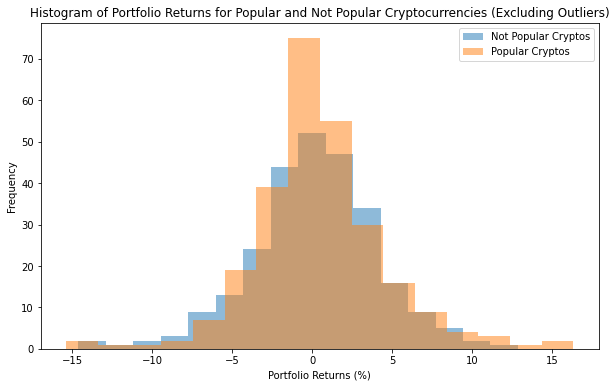

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Calculate the quartiles for not popular cryptos
q1 = np.percentile(not_popular_crypto_returns_complete['Portfolio_Return'].dropna(), 25)
q3 = np.percentile(not_popular_crypto_returns_complete['Portfolio_Return'].dropna(), 75)
iqr = q3 - q1

# Calculate the lower and upper bounds for not popular cryptos (1.5 times IQR)
lower_bound_not_popular = q1 - 1.5 * iqr
upper_bound_not_popular = q3 + 1.5 * iqr

# Filter out the outliers for not popular cryptos
not_popular_crypto_returns_no_outliers = not_popular_crypto_returns_df[
    (not_popular_crypto_returns_df['Portfolio_Return'] >= lower_bound_not_popular) &
    (not_popular_crypto_returns_df['Portfolio_Return'] <= upper_bound_not_popular)
]

# Calculate the quartiles for popular cryptos
q1_popular = np.percentile(popular_crypto_returns_complete['Portfolio_Return'].dropna(), 25)
q3_popular = np.percentile(popular_crypto_returns_complete['Portfolio_Return'].dropna(), 75)
iqr_popular = q3_popular - q1_popular

# Calculate the lower and upper bounds for popular cryptos (1.5 times IQR)
lower_bound_popular = q1_popular - 1.5 * iqr_popular
upper_bound_popular = q3_popular + 1.5 * iqr_popular

# Filter out the outliers for popular cryptos
popular_crypto_returns_no_outliers = popular_crypto_returns_df[
    (popular_crypto_returns_df['Portfolio_Return'] >= lower_bound_popular) &
    (popular_crypto_returns_df['Portfolio_Return'] <= upper_bound_popular)
]

# Calculate the number of bins using Freedman-Diaconis rule for not popular cryptos
n_bins_not_popular = int(np.sqrt(len(not_popular_crypto_returns_no_outliers)))

# Calculate the number of bins using Freedman-Diaconis rule for popular cryptos
n_bins_popular = int(np.sqrt(len(popular_crypto_returns_no_outliers)))

# Plotting histograms for portfolio returns of both DataFrames
plt.figure(figsize=(10, 6))

# Histogram for not popular cryptocurrencies portfolio returns
plt.hist(not_popular_crypto_returns_no_outliers['Portfolio_Return'] * 100, bins=n_bins_not_popular, alpha=0.5, label='Not Popular Cryptos')

# Histogram for popular cryptocurrencies portfolio returns
plt.hist(popular_crypto_returns_no_outliers['Portfolio_Return'] * 100, bins=n_bins_popular, alpha=0.5, label='Popular Cryptos')

plt.xlabel('Portfolio Returns (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Portfolio Returns for Popular and Not Popular Cryptocurrencies (Excluding Outliers)')
plt.legend()

# Show plot
plt.show()


## Student's t-test
When we set a significance level of 5%, the analysis suggests that there is not enough evidence to reject the null hypothesis. However, with a significance level of 10%, there is sufficient evidence to reject the null hypothesis.

The t-statistic in a t-test tells us how many standard errors the sample mean of one group (in this case, the not-popular portfolio) is from the sample mean of the other group (the popular portfolio). The sign of this statistic can indicate the direction of the difference, if a difference exists.

* If the t-statistic is positive, it suggests that the mean portfolio return of the not-popular portfolio is greater than that of the popular portfolio.
* Conversely, if the t-statistic is negative, it suggests the mean portfolio return of the popular portfolio is greater than that of the not-popular portfolio.
Therefore, when interpreting the results, we can consider the sign of the t-statistic as a clue to the direction of the difference between the two groups, if there is indeed a difference.

This approach allows for a nuanced understanding of the comparison between the not-popular and popular portfolios, shedding light on potential differences in their returns.

In [10]:
from scipy.stats import ttest_ind

# equal_var is to use the normal distribution approximation for the hypothesis test
# Perform the t-test on filtered data
statistic, p_value = ttest_ind(not_popular_crypto_returns_complete['Portfolio_Return'], popular_crypto_returns_complete['Portfolio_Return'], equal_var=True)

# Calculate standard error for each DataFrame
standard_error_not_popular = not_popular_crypto_returns_complete['Portfolio_Return'].std() / np.sqrt(len(not_popular_crypto_returns_complete))
standard_error_popular = popular_crypto_returns_complete['Portfolio_Return'].std() / np.sqrt(len(popular_crypto_returns_complete))

# Print the results
print("t-Test Results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")
print(f"Standard Error for Non-Popular Crypto Portfolio: {standard_error_not_popular}")
print(f"Standard Error for Popular Crypto Portfolio: {standard_error_popular}")

# Interpret the results
alpha = 0.1
if p_value < alpha:
    print("The null hypothesis can be rejected. There is a significant difference in the portfolio returns.")
else:
    print("The null hypothesis cannot be rejected. There is no significant difference in the portfolio returns.")


t-Test Results:
Statistic: 1.7101977735514962
P-value: 0.08754262674482284
Standard Error for Non-Popular Crypto Portfolio: 0.05066849898836469
Standard Error for Popular Crypto Portfolio: 0.003803555985481287
The null hypothesis can be rejected. There is a significant difference in the portfolio returns.


In [11]:
from scipy.stats import ttest_ind

# Compute the mean values
mean_not_popular = not_popular_crypto_returns_complete['Portfolio_Return'].mean() * 100
mean_popular = popular_crypto_returns_complete['Portfolio_Return'].mean() * 100

# Print the mean values
print("Mean Portfolio Returns:")
print(f"Not Popular Crypto Portfolio Mean Return: {mean_not_popular:.2f}%")
print(f"Popular Crypto Portfolio Mean Return: {mean_popular:.2f}%")


Mean Portfolio Returns:
Not Popular Crypto Portfolio Mean Return: 10.23%
Popular Crypto Portfolio Mean Return: 1.54%


The diffrence in stantdard errors could be explained by various factors, including:

* Difference in sample size between the two portfolios.
* Difference in variability of the two groups of portfolios.

In [12]:
from scipy.stats import ttest_ind

# Define the date for splitting the data
split_date_index = '2017-12-31'  # Replace 'YYYY-MM-DD' with the desired date

# Split the data based on the defined date
first_half_not_popular_returns = not_popular_crypto_returns_complete.loc[:split_date_index, 'Portfolio_Return']
second_half_not_popular_returns = not_popular_crypto_returns_complete.loc[split_date_index:, 'Portfolio_Return']
first_half_popular_returns = popular_crypto_returns_complete.loc[:split_date_index, 'Portfolio_Return']
second_half_popular_returns = popular_crypto_returns_complete.loc[split_date_index:, 'Portfolio_Return']

# Perform the t-test for the first half of the data
statistic_1, p_value_1 = ttest_ind(first_half_not_popular_returns, first_half_popular_returns, equal_var=True)

# Perform the t-test for the second half of the data
statistic_2, p_value_2 = ttest_ind(second_half_not_popular_returns, second_half_popular_returns, equal_var=True)

# Print the results for the first half of the data
print("t-Test Results for the first half of the data (up to", split_date_index, "):")
print(f"Statistic: {statistic_1}")
print(f"P-value: {p_value_1}")

# Interpret the results for the first half of the data
alpha = 0.1
if p_value_1 < alpha:
    print("The null hypothesis can be rejected for the first half. There is a significant difference in the portfolio returns.")
else:
    print("The null hypothesis cannot be rejected for the first half. There is no significant difference in the portfolio returns.")

# Print the results for the second half of the data
print("\nt-Test Results for the second half of the data (from", split_date_index, "onwards):")
print(f"Statistic: {statistic_2}")
print(f"P-value: {p_value_2}")

# Interpret the results for the second half of the data
if p_value_2 < alpha:
    print("The null hypothesis can be rejected for the second half. There is a significant difference in the portfolio returns.")
else:
    print("The null hypothesis cannot be rejected for the second half. There is no significant difference in the portfolio returns.")


t-Test Results for the first half of the data (up to 2017-12-31 ):
Statistic: 0.8183050104903246
P-value: 0.41375282729863794
The null hypothesis cannot be rejected for the first half. There is no significant difference in the portfolio returns.

t-Test Results for the second half of the data (from 2017-12-31 onwards):
Statistic: 1.6448300655332693
P-value: 0.1004898370462637
The null hypothesis cannot be rejected for the second half. There is no significant difference in the portfolio returns.


# Regression and zero-investment portfolio

## Zero investment portfolio

In [13]:
zero_investment_df = pd.DataFrame()

# Compute the zero investment portfolio returns
zero_investment_df["Returns_zero"] = popular_crypto_returns_df["Portfolio_Return"] - not_popular_crypto_returns_df["Portfolio_Return"] 

## Regression

In [14]:
from sklearn.linear_model import LinearRegression
from scipy.stats import t

data = pd.concat([zero_investment_df["Returns_zero"], index_data['Weekly_Return']], axis=1).dropna()

# Define the dependent and independent variables
X = data[["Weekly_Return"]]
y = data["Returns_zero"]

# Create a Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Compute predictions
predictions = model.predict(X)

# Compute error (residuals)
error = y - predictions
data["error"] = error

# Calculate standard errors of the coefficients
n = len(X)
p = X.shape[1]
residual_std_error = np.sqrt(np.sum(error ** 2) / (n - p - 1))
X_with_intercept = np.column_stack([np.ones(n), X.values])  # Add intercept column
XtXi = np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept))
standard_errors = np.sqrt(np.diagonal(residual_std_error ** 2 * XtXi))

# Compute t-values
t_values = model.coef_ / standard_errors  # For the coefficients

# Degrees of freedom for the t-distribution
df_t = n - p - 1

# Compute p-values
p_values = 2 * (1 - t.cdf(np.abs(t_values), df=df_t))

# Print the intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])

# Print the R-squared value
print("R-squared:", model.score(X, y))
# Compute the adjusted R-squared value
adjusted_r_squared = 1 - (1 - model.score(X, y)) * (n - 1) / (n - p - 1)

# Print the adjusted R-squared value
print("Adjusted R-squared:", adjusted_r_squared)


# Display p-values
print("Hypothesis test p-values:")
for i, p_value in enumerate(p_values):
    print(f"Coefficient {i}: {p_value}")


c:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
c:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
c:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specificall

Intercept: 0.0024172749653549037
Coefficient: 0.007845631947456905
R-squared: 0.0022362588383537663
Adjusted R-squared: -0.0015431492721069695
Hypothesis test p-values:
Coefficient 0: 1.6231460620019789e-12
Coefficient 1: 0.4424518653771914


c:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\randomized_l1.py:152: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  precompute=False, eps=np.finfo(np.float).eps,
c:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\randomized_l1.py:320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, rand

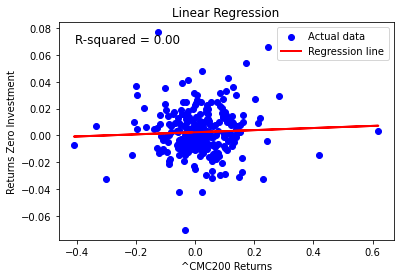

In [15]:
import matplotlib.pyplot as plt

# Scatter plot of the data
plt.scatter(X, y, color='blue', label='Actual data')

# Plot the regression line
plt.plot(X, predictions, color='red', linewidth=2, label='Regression line')

# Add R-squared value
plt.text(0.05, 0.95, f'R-squared = {model.score(X, y):.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top')

# Add labels and title
plt.xlabel('^CMC200 Returns')
plt.ylabel('Returns Zero Investment')
plt.title('Linear Regression')
plt.legend()

# Show plot
plt.show()


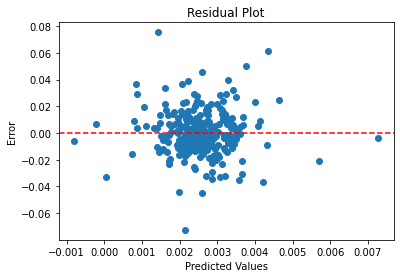

In [16]:
import matplotlib.pyplot as plt

# Scatter plot of predicted values vs. errors
plt.scatter(predictions, error)
plt.xlabel("Predicted Values")
plt.ylabel("Error")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at y=0
plt.show()

In [17]:
# FACTOR POPOULAR PORTAFOLIO INVERSIÓN CERO
data[['Returns_zero', 'Weekly_Return']].to_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Fama-macBeth data\Reg_factors_ZI.xlsx")
data[['error', 'Weekly_Return']].to_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Fama-macBeth data\Reg_factors_green.xlsx")


# Portfolio Building

The process consists of running regressions for each crypto, where the only factore is the popular factor.

$$
R_{i,t} = a_{i} + \beta_{i}\cdot R_{p, t} + e_{i,t}\;.
$$

Then compute the $\beta$ for each crypto $i$, and order them in descending order by those values. The portfolios will be comprised in that order using a certain ammount of cryptos (10 or 24 approx.) using a value weighted or equally weighted approach.

In [18]:
# Dataset that contains the returns of all cryptocurrencies
filtered_returns = filtered_returns[['Date', 'Symbol', 'Daily Returns']].pivot(index='Date', columns='Symbol', values='Daily Returns')


# ACÁ EDITÉ EL CÓDIGO
# filtered_returns["Popular_factor"] = data["Returns_zero"]

filtered_returns["Popular_factor"] = error

filtered_returns["Popular_factor"] = pd.to_numeric(filtered_returns["Popular_factor"], errors='coerce')

# Drop symbols with all missing values
filtered_returns.dropna(axis=1, how='all', inplace=True)



In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Initialize an empty DataFrame to store beta values
beta_df = pd.DataFrame(columns=["Symbol", "Beta"], dtype=float)

# Iterate over each symbol
for symbol in filtered_returns.columns[:-1]:  # Exclude the "Popular_factor" column
    # Get the returns of the cryptocurrency and the popular factor
    df_aux = filtered_returns.dropna(subset=["Popular_factor", symbol])
    X = df_aux["Popular_factor"].values.reshape(-1, 1)
    y = df_aux[symbol].values.reshape(-1, 1)
    
    # Create a Linear Regression model
    model = LinearRegression()
    
    # Fit the model
    model.fit(X, y)
    
    # Get the beta (slope coefficient)
    beta = model.coef_[0][0]
    
    # Append the symbol and beta to the beta_df
    beta_df = beta_df.append({"Symbol": symbol, "Beta": beta}, ignore_index=True)

# Display the beta DataFrame
display(beta_df)


,Symbol,Beta
0,0X0-USD,2.238288
1,1000SATS-USD,0.836775
2,1INCH-USD,-1.695174
3,AAVE-USD,-1.654751
4,ADA-USD,-0.796897
5,AGI-USD,-3.215645
6,AGIX-USD,-1.392091
7,AIOZ-USD,-1.686085
8,AKT-USD,-1.068268
9,ALGO-USD,-1.200452


In [20]:
# Sort the beta_df DataFrame by Beta in descending order
sorted_beta_df = beta_df.sort_values(by="Beta", ascending=False)

# Initialize an empty list to store lists of symbols
symbol_lists = []

# Number of cryptos in the portfolios
chunk_size = 26
num_chunks = len(sorted_beta_df) // chunk_size + (1 if len(sorted_beta_df) % chunk_size != 0 else 0)

for i in range(num_chunks):
    # Extract symbols for the current chunk
    symbols_chunk = sorted_beta_df.iloc[i * chunk_size: (i + 1) * chunk_size]["Symbol"].tolist()
    # Append the symbols to the symbol_lists
    symbol_lists.append(symbols_chunk)

# Display the symbol lists
for i, symbol_list in enumerate(symbol_lists):
    print(f"List {i + 1}: {symbol_list}")
    print(len(symbol_list))


List 1: ['0X0-USD', 'TNC5524-USD', 'BEAM28298-USD', 'MEME28301-USD', 'ZBU-USD', '1000SATS-USD', 'ZETA-USD', 'MNT27075-USD', 'DESO-USD', 'WBTC-USD', 'BTC-USD', 'BTCB-USD', 'BGB-USD', 'WBETH-USD', 'BORG-USD', 'FTN-USD', 'CBETH-USD', 'CHEEL-USD', 'XAUT-USD', 'PAXG-USD', 'SEI-USD', 'CFG-USD', 'ORBR-USD', 'RETH-USD', 'MOBILE-USD', 'OP-USD']
26
List 2: ['RON14101-USD', 'LEO-USD', 'XEC-USD', 'WTRX-USD', 'ARKM-USD', 'PRIME23711-USD', 'WIF-USD', 'XDC-USD', 'AZERO-USD', 'XRD-USD', 'ORDI-USD', 'TAO22974-USD', 'AXL17799-USD', 'MSOL-USD', 'XMR-USD', 'GMX11857-USD', 'HOT2682-USD', 'DCR-USD', 'ETH-USD', 'ARB11841-USD', 'SSV-USD', 'LPT-USD', 'OSMO-USD', 'IOTA-USD', 'ETHW-USD', 'CRO-USD']
26
List 3: ['RPL-USD', 'GNO-USD', 'NEXO-USD', 'TEL-USD', 'FLR-USD', 'SOL-USD', 'BNB-USD', 'QNT-USD', 'MAGIC14783-USD', 'OKB-USD', 'CORE23254-USD', 'KAS-USD', 'NTRN26680-USD', 'ELF-USD', 'DASH-USD', 'FLUX-USD', 'ADA-USD', 'GLM-USD', 'GF15585-USD', 'LTC-USD', 'GT-USD', 'ZEC-USD', 'CFX-USD', 'GAS-USD', 'HNT-USD', 'ANKR-U

## Return Computation

### Equally weighted

In [21]:
# Define df_portfolio_returns with the same index as returns_df
df_portfolio_returns = pd.DataFrame(index=filtered_returns.index)

i = 1
for p in symbol_lists:

    # Filter the filtered_returns DataFrame for the cryptocurrencies in the portfolio
    returns_df = filtered_returns[p]

    # Initialize an empty DataFrame to store the portfolio return for each date
    portfolio_returns = pd.DataFrame(index=returns_df.index, columns=[f'Portfolio_{i}'], dtype=float)

    # Iterate over each date to calculate the portfolio return
    for date in returns_df.index:
        # Filter the cryptocurrencies available on this date
        available_cryptos = returns_df.loc[date].dropna().index

        # Get the number of cryptocurrencies in the portfolio on this date
        num_cryptos = len(available_cryptos)
        
        # Check if there are cryptocurrencies available in the portfolio
        if num_cryptos > 0:
            # Equally weight the portfolio based on the number of cryptocurrencies
            weight_per_crypto = 1 / num_cryptos
            
            # Create equally weighted portfolio weights
            available_weights = pd.Series([float(weight_per_crypto)] * len(available_cryptos), index=available_cryptos)

            # Filter the returns for available cryptocurrencies
            available_returns = returns_df.loc[date, available_cryptos]
        
            # Calculate the portfolio return for this date (equally weighted)
            portfolio_return_date = (available_returns * available_weights).sum()

            # Assign the portfolio return for this date to the DataFrame
            portfolio_returns.loc[date, f'Portfolio_{i}'] = portfolio_return_date
        else:
            # If there are no cryptocurrencies available, set portfolio return as NaN
            portfolio_returns.loc[date, f'Portfolio_{i}'] = np.nan
    
    # Concatenate the portfolio returns DataFrame with df_portfolio_returns
    df_portfolio_returns = pd.concat([df_portfolio_returns, portfolio_returns], axis=1)

    i += 1


In [22]:
df_portfolio_returns.to_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Fama-macBeth data\Portfolio returns\Portfolio_returns_26_EW_green.xlsx")

### Value weighted

In [23]:
# Define df_portfolio_returns with the same index as returns_df
df_portfolio_returns = pd.DataFrame(index=filtered_returns.index)

i = 1
for p in symbol_lists:

    # Filter the filtered_returns DataFrame for the cryptocurrencies in the portfolio
    returns_df = filtered_returns[p]

    # Initialize an empty DataFrame to store the portfolio return for each date
    portfolio_returns = pd.DataFrame(index=returns_df.index, columns=[f'Portfolio_{i}'], dtype=float)

    # Iterate over each date to calculate the portfolio return
    for date in returns_df.index:
        # Filter the cryptocurrencies available on this date
        available_cryptos = returns_df.loc[date].dropna().index

        num_cryptos = len(available_cryptos)

        # Check if there are cryptocurrencies available in the portfolio
        if num_cryptos > 0:
            # Filter the market capitalizations for available cryptocurrencies
            available_market_caps = df_market_cap[df_market_cap['Symbol'].isin(available_cryptos)].set_index('Symbol')['Market_cap']
            
            # Set the index of available_weights to be the symbol column
            available_weights = available_market_caps.reset_index(drop=True)
            
            # Calculate the total market cap of available cryptocurrencies for this date
            total_market_cap = available_market_caps.sum()

            available_weights = available_market_caps / total_market_cap
            
            # Filter the returns for available cryptocurrencies
            available_returns = returns_df.loc[date, available_cryptos]
            
            # Calculate the weighted returns (Important that thes dfs have the same index, Symbols)
            weighted_returns = available_returns * available_weights
            
            # Calculate the portfolio return for this date (value-weighted)
            portfolio_return_date = weighted_returns.sum()
            
            # Assign the portfolio return for this date to the DataFrame
            portfolio_returns.loc[date, f'Portfolio_{i}'] = portfolio_return_date
        else:
            # If there are no cryptocurrencies available, set portfolio return as NaN
            portfolio_returns.loc[date, f'Portfolio_{i}'] = np.nan
    
    # Concatenate the portfolio returns DataFrame with df_portfolio_returns
    df_portfolio_returns = pd.concat([df_portfolio_returns, portfolio_returns], axis=1)

    i += 1


In [24]:
df_portfolio_returns.to_excel(r"C:\Users\USER\OneDrive\Escritorio\Memoria\Memoria_LA\Fama-macBeth data\Portfolio returns\Portfolio_returns_26_VW.xlsx")